<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_15_resampling_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Description

We are working on a classification task to predict loan defaults using the "Default of Credit Card Clients" dataset. The target variable is highly imbalanced, with significantly more instances of one class (non-defaults) compared to the other (defaults). Our goal is to improve the recall for the minority class (defaults) while maintaining a balanced F1 score and F1 macro score.

### Previous Observations

Using a Logistic Regression model, we observed that applying random oversampling both inside and outside the pipeline resulted in nearly identical performance metrics compared to the baseline model without any resampling. This suggests that the Logistic Regression model might not be adequately capturing the benefits of resampling.

### Experimental Approach with Random Forest

To address this issue, we decided to experiment with a Random Forest (RF) model, which might be better suited to handle the complexities of the imbalanced dataset. Our experimental approach involves three main steps:

1. **Baseline Model**: Train and evaluate a Random Forest model without any resampling.
2. **Resampling Inside the Pipeline**: Integrate random oversampling within the pipeline and evaluate the performance.
3. **Resampling Outside the Pipeline**: Apply random oversampling before fitting the pipeline and evaluate the performance.

### Experimental Setup

#### 1. Baseline Model

We define and train a baseline Random Forest model without any resampling. The performance metrics (recall for class 1, balanced F1 score, and macro F1 score) are calculated using an optimal threshold of 0.25.

#### 2. Model with Resampling Inside the Pipeline

We integrate the random oversampling step within the pipeline and train the Random Forest model on the resampled data. This approach ensures that the resampling is applied as part of the overall pipeline workflow.

#### 3. Model with Resampling Outside the Pipeline

We apply random oversampling to the training data before fitting the pipeline. The Random Forest model is then trained on the resampled data, and performance metrics are calculated using the same optimal threshold.

### Evaluation and Comparison

After training and evaluating the models, we combine the results into a single DataFrame and visualize the performance metrics to compare the effectiveness of each approach. By doing so, we aim to identify whether the Random Forest model benefits from resampling and how it compares to the baseline model.

### Conclusion

By experimenting with a Random Forest model and applying resampling both inside and outside the pipeline, we aim to improve the recall for the minority class and achieve better overall performance metrics. This approach will help us understand the impact of resampling on different models and guide us towards selecting the most effective strategy for handling imbalanced datasets.

### No Resampling Baseline Model

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, f1_score
from loan_data_utils import load_and_preprocess_data
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Create the baseline pipeline
baseline_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

# Fit the baseline pipeline to the training data
baseline_pipeline_rf.fit(X_train, y_train)

# Predict probabilities for the test data
optimal_threshold = 0.25
baseline_y_proba_rf = baseline_pipeline_rf.predict_proba(X_test)[:, 1]
baseline_y_pred_rf = (baseline_y_proba_rf >= optimal_threshold).astype(int)

# Evaluate the baseline model
baseline_recall_class1_rf = recall_score(y_test, baseline_y_pred_rf, pos_label=1)
baseline_f1_balanced_rf = f1_score(y_test, baseline_y_pred_rf, average='binary', pos_label=1)
baseline_f1_macro_rf = f1_score(y_test, baseline_y_pred_rf, average='macro')

print("Baseline RF Model Performance with Optimal Threshold:")
print(f"Recall Class 1: {baseline_recall_class1_rf:.4f}")
print(f"F1 Score (balanced): {baseline_f1_balanced_rf:.4f}")
print(f"F1 Score (macro): {baseline_f1_macro_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, baseline_y_pred_rf))

# Save the baseline results
baseline_results_rf = {
    'Method': 'Baseline RF',
    'Recall Class 1': baseline_recall_class1_rf,
    'F1 Score (balanced)': baseline_f1_balanced_rf,
    'F1 Score (macro)': baseline_f1_macro_rf,
    'Threshold': 'Optimal (0.25)'
}


Baseline RF Model Performance with Optimal Threshold:
Recall Class 1: 0.5998
F1 Score (balanced): 0.5215
F1 Score (macro): 0.6791

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      4673
           1       0.46      0.60      0.52      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.78      0.76      0.77      6000



### Resampling inside Pipeline



In [5]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

# Define the resampling method
resampler_inside_rf = RandomOverSampler(random_state=42)

# Create the resampled pipeline
resampled_pipeline_inside_rf = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', resampler_inside_rf),
    ('classifier', rf_model)
])

# Fit the resampled pipeline to the training data
resampled_pipeline_inside_rf.fit(X_train, y_train)

# Predict probabilities for the test data
resampled_y_proba_inside_rf = resampled_pipeline_inside_rf.predict_proba(X_test)[:, 1]
resampled_y_pred_inside_rf = (resampled_y_proba_inside_rf >= optimal_threshold).astype(int)

# Evaluate the model
resampled_recall_class1_inside_rf = recall_score(y_test, resampled_y_pred_inside_rf, pos_label=1)
resampled_f1_balanced_inside_rf = f1_score(y_test, resampled_y_pred_inside_rf, average='binary', pos_label=1)
resampled_f1_macro_inside_rf = f1_score(y_test, resampled_y_pred_inside_rf, average='macro')

print("Resampled RF Model Performance with Optimal Threshold (Inside Pipeline):")
print(f"Recall Class 1: {resampled_recall_class1_inside_rf:.4f}")
print(f"F1 Score (balanced): {resampled_f1_balanced_inside_rf:.4f}")
print(f"F1 Score (macro): {resampled_f1_macro_inside_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, resampled_y_pred_inside_rf))

# Save the resampled results
resampled_results_inside_rf = {
    'Method': 'Random Oversampling RF (Inside Pipeline)',
    'Recall Class 1': resampled_recall_class1_inside_rf,
    'F1 Score (balanced)': resampled_f1_balanced_inside_rf,
    'F1 Score (macro)': resampled_f1_macro_inside_rf,
    'Threshold': 'Optimal (0.25)'
}


Resampled RF Model Performance with Optimal Threshold (Inside Pipeline):
Recall Class 1: 0.6956
F1 Score (balanced): 0.4836
F1 Score (macro): 0.6214

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.66      0.76      4673
           1       0.37      0.70      0.48      1327

    accuracy                           0.67      6000
   macro avg       0.63      0.68      0.62      6000
weighted avg       0.77      0.67      0.70      6000



### Resampling Outside Pipeline

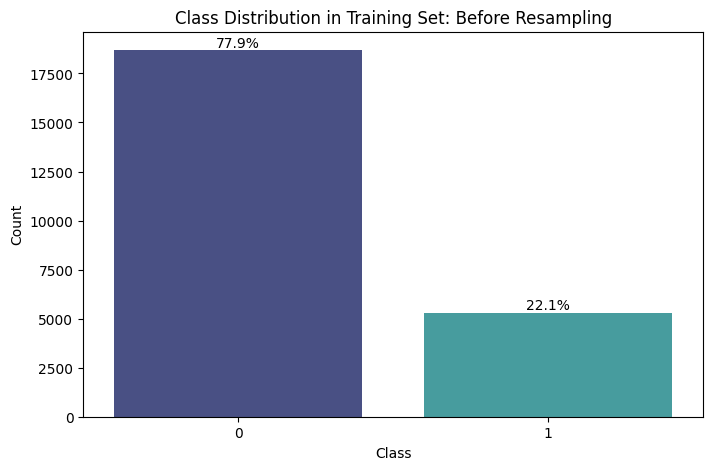

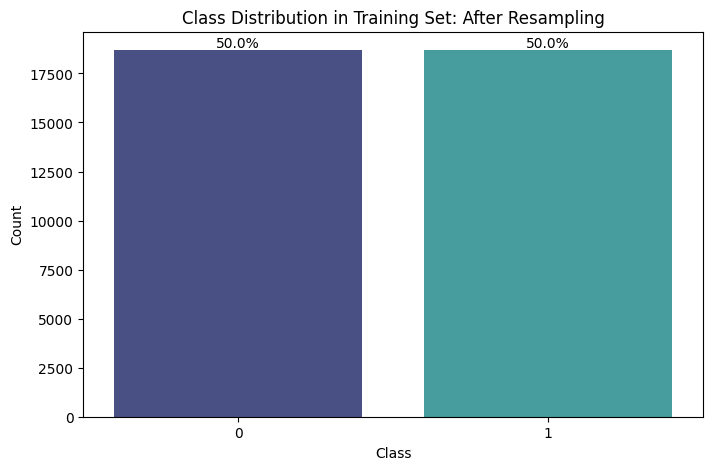

Resampled RF Model Performance with Optimal Threshold (Outside Pipeline):
Recall Class 1: 0.6971
F1 Score (balanced): 0.4837
F1 Score (macro): 0.6210

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.66      0.76      4673
           1       0.37      0.70      0.48      1327

    accuracy                           0.67      6000
   macro avg       0.63      0.68      0.62      6000
weighted avg       0.77      0.67      0.70      6000



In [6]:
# Define the resampling method
resampler_outside_rf = RandomOverSampler(random_state=42)

# Resample the training data
X_resampled_outside_rf, y_resampled_outside_rf = resampler_outside_rf.fit_resample(X_train, y_train)

# Plot class distribution before resampling
plot_class_distribution(y_train, 'Before Resampling')

# Plot class distribution after resampling
plot_class_distribution(y_resampled_outside_rf, 'After Resampling')

# Create the pipeline
pipeline_outside_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

# Fit the pipeline to the resampled training data
pipeline_outside_rf.fit(X_resampled_outside_rf, y_resampled_outside_rf)

# Predict probabilities for the test data
resampled_y_proba_outside_rf = pipeline_outside_rf.predict_proba(X_test)[:, 1]
resampled_y_pred_outside_rf = (resampled_y_proba_outside_rf >= optimal_threshold).astype(int)

# Evaluate the model
resampled_recall_class1_outside_rf = recall_score(y_test, resampled_y_pred_outside_rf, pos_label=1)
resampled_f1_balanced_outside_rf = f1_score(y_test, resampled_y_pred_outside_rf, average='binary', pos_label=1)
resampled_f1_macro_outside_rf = f1_score(y_test, resampled_y_pred_outside_rf, average='macro')

print("Resampled RF Model Performance with Optimal Threshold (Outside Pipeline):")
print(f"Recall Class 1: {resampled_recall_class1_outside_rf:.4f}")
print(f"F1 Score (balanced): {resampled_f1_balanced_outside_rf:.4f}")
print(f"F1 Score (macro): {resampled_f1_macro_outside_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, resampled_y_pred_outside_rf))

# Save the resampled results
resampled_results_outside_rf = {
    'Method': 'Random Oversampling RF (Outside Pipeline)',
    'Recall Class 1': resampled_recall_class1_outside_rf,
    'F1 Score (balanced)': resampled_f1_balanced_outside_rf,
    'F1 Score (macro)': resampled_f1_macro_outside_rf,
    'Threshold': 'Optimal (0.25)'
}


###Compare Results

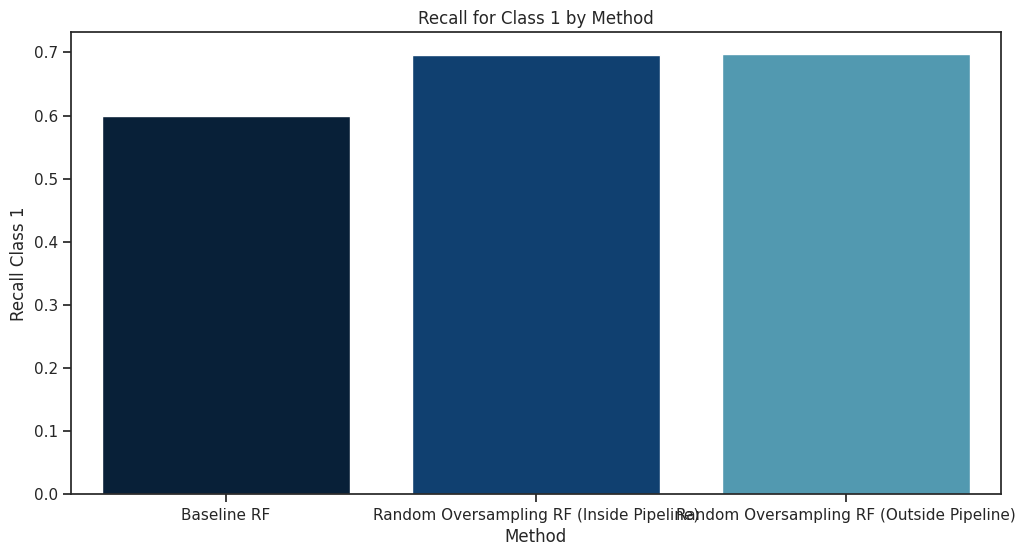

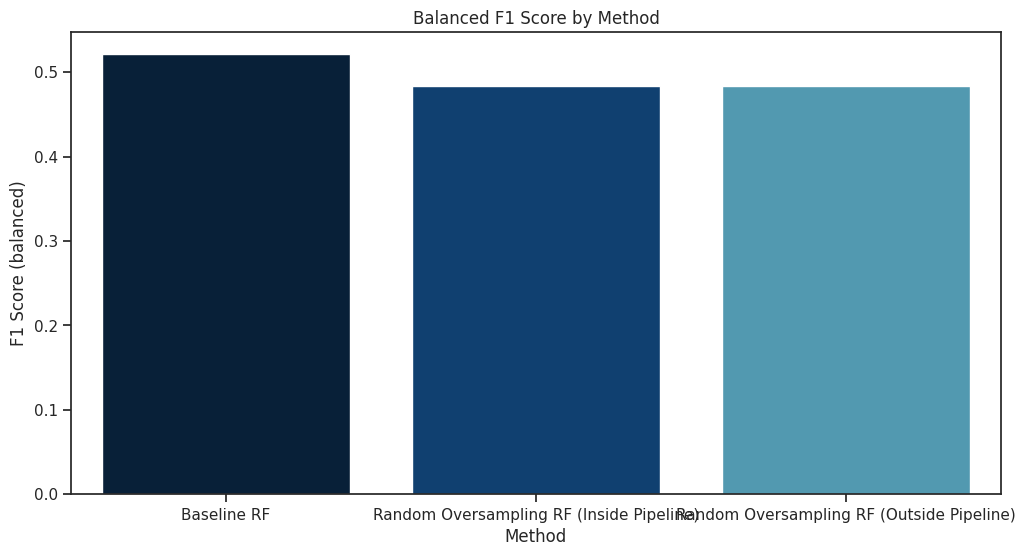

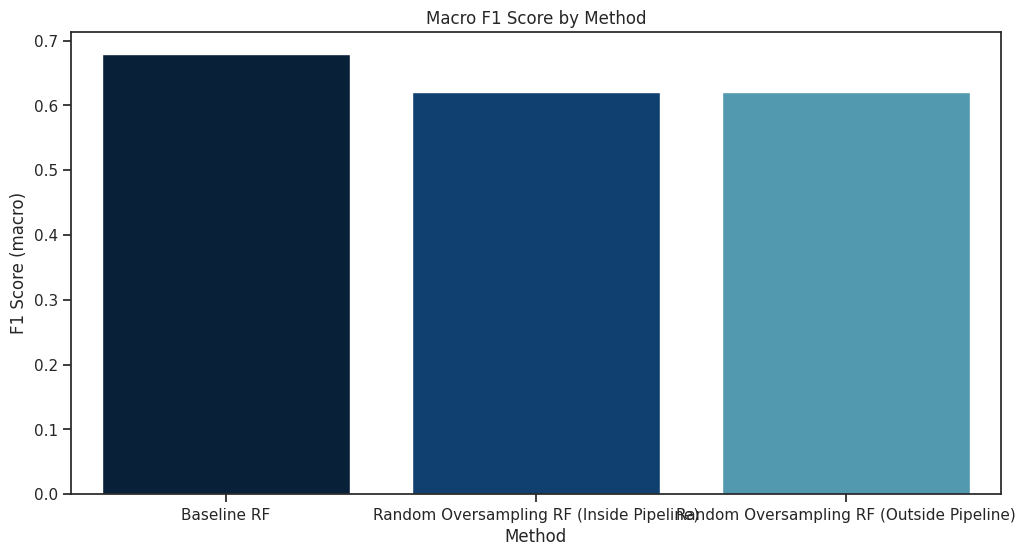

In [11]:
# Combine the results into a single DataFrame
results_df_rf = pd.DataFrame([baseline_results_rf, resampled_results_inside_rf, resampled_results_outside_rf])

# Function to plot the performance metrics for combined results
def plot_combined_metrics(results_df, metric, title, ylabel):
    sns.set_context('notebook')
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.barplot(x='Method', y=metric, hue='Method', data=results_df, palette='ocean', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Method')
    ax.set_ylabel(ylabel)

    plt.show()

# Metrics to plot
metrics = [
    ('Recall Class 1', 'Recall for Class 1 by Method', 'Recall Class 1'),
    ('F1 Score (balanced)', 'Balanced F1 Score by Method', 'F1 Score (balanced)'),
    ('F1 Score (macro)', 'Macro F1 Score by Method', 'F1 Score (macro)')
]

# Loop through the metrics and create plots
for metric, title, ylabel in metrics:
    plot_combined_metrics(results_df_rf, metric, title, ylabel)


In [12]:
# Display the combined results
print("Combined Performance Metrics:")
results_df_rf

Combined Performance Metrics:


,Method,Recall Class 1,F1 Score (balanced),F1 Score (macro),Threshold
0,Baseline RF,0.599849,0.521454,0.679080,Optimal (0.25)
1,Random Oversampling RF (Inside Pipeline),0.695554,0.483626,0.621380,Optimal (0.25)
2,Random Oversampling RF (Outside Pipeline),0.697061,0.483660,0.621035,Optimal (0.25)


### Analysis of Results

#### Overview

We experimented with three different setups to improve the recall of the minority class (loan defaults) in our classification task using a Random Forest (RF) model. The results are summarized as follows:

| Method                                   | Recall Class 1 | F1 Score (balanced) | F1 Score (macro) | Threshold    |
|------------------------------------------|----------------|---------------------|------------------|--------------|
| Baseline RF                              | 0.599849       | 0.521454            | 0.679080         | Optimal (0.25) |
| Random Oversampling RF (Inside Pipeline) | 0.695554       | 0.483626            | 0.621380         | Optimal (0.25) |
| Random Oversampling RF (Outside Pipeline)| 0.697061       | 0.483660            | 0.621035         | Optimal (0.25) |

### Detailed Analysis

1. **Baseline RF Model**:
   - **Recall Class 1**: 0.599849
   - **F1 Score (balanced)**: 0.521454
   - **F1 Score (macro)**: 0.679080
   
   The baseline RF model achieves a recall of approximately 0.60 for the minority class (class 1). This indicates that 60% of actual defaults are correctly identified. The balanced F1 score and macro F1 score are relatively high, showing that the model performs well overall.

2. **Random Oversampling RF (Inside Pipeline)**:
   - **Recall Class 1**: 0.695554
   - **F1 Score (balanced)**: 0.483626
   - **F1 Score (macro)**: 0.621380

   When random oversampling is applied inside the pipeline, the recall for class 1 improves significantly to approximately 0.70. This means that the model is now correctly identifying 70% of actual defaults. However, the balanced F1 score and macro F1 score drop compared to the baseline, indicating that the model's precision may have decreased, or it might be misclassifying more instances of the majority class.

3. **Random Oversampling RF (Outside Pipeline)**:
   - **Recall Class 1**: 0.697061
   - **F1 Score (balanced)**: 0.483660
   - **F1 Score (macro)**: 0.621035

   Applying random oversampling outside the pipeline yields similar results to the inside pipeline approach, with a slight improvement in recall to approximately 0.70. The balanced F1 score and macro F1 score remain similar to those of the inside pipeline method.

### Interpretation

- **Recall Improvement**: Both resampling methods (inside and outside the pipeline) significantly improve the recall for the minority class compared to the baseline model. This indicates that resampling helps the RF model better identify loan defaults.
- **Balanced and Macro F1 Score Decrease**: The drop in balanced F1 and macro F1 scores suggests a trade-off between improving recall and maintaining precision. While the model becomes better at identifying defaults, it might be misclassifying more non-defaults as defaults, leading to lower precision.
- **Consistent Results for Resampling Methods**: The similar performance of resampling inside and outside the pipeline suggests that the choice between these methods may not have a significant impact on the RF model's performance for this dataset.

### Recommendations

1. **Further Hyperparameter Tuning**: To improve both recall and precision, consider performing hyperparameter tuning for the RF model using techniques like grid search or randomized search.
2. **Try Other Resampling Methods**: Experiment with other resampling methods like SMOTE, ADASYN, or combinations of oversampling and undersampling to see if they offer better trade-offs between recall and precision.
3. **Model Comparison**: Compare the performance of the RF model with other classifiers, such as Gradient Boosting or XGBoost, which might offer better handling of imbalanced data.
4. **Evaluate Business Impact**: Consider the business implications of misclassifications. Improving recall might be beneficial if the cost of missing a default is high, even if it comes at the expense of some precision.

By following these recommendations, you can further refine the model and potentially achieve better performance for the loan default prediction task.

### Write Loan Data Utils Script

In [1]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *


Script successfully written to loan_data_utils.py
